### Part I. Live Tickers Halts + Resumptions (OMIT and USE Historicals ONLY)

In [6]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from lxml import etree
import codecs
from datetime import date,timedelta,datetime
import calendar
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

def currentDate():
    curr_date = date.today()
    if (calendar.day_name[curr_date.weekday()]) == 'Saturday':
        curr_date = curr_date - timedelta(days=1)

    elif (calendar.day_name[curr_date.weekday()]) == 'Sunday':
        curr_date = curr_date - timedelta(days=2)
        
    curr_date = str(curr_date)
    
    return curr_date

def haltsResumptionsList():
    halts_resumptions = []

    for i in range(1,100,1):
        try:
            halts_resumptions.append(driver.find_element_by_xpath(f'/html/body/table/tbody/tr/td/div/div/div[2]/div/table/tbody/tr[{i}]/td/div/div[2]/a').text)
        except Exception as e:
            pass
    return halts_resumptions

def currentHalts(halts_resumptions,date_today):
    base_url = 'https://iiroc.mediaroom.com/'

    haltURL = []

    for value in halts_resumptions:
        haltURL.append((date_today + '-' + value).replace(" ","-").replace("---","-").replace('.','-'))
        
    completeUrl = []

    for text in haltURL:
        completeUrl.append(base_url+text)
        
    return completeUrl 

def generateHaltResumptions(HR):

    haltsLive = []
    resumptionsLive = []
    othersLive = []

    for value in HR:
        if 'Resumption' in value:
            resumptionsLive.append(value)    
        elif 'Halt' in  value:
            haltsLive.append(value)
        else:
            othersLive.append(value)

    for url in othersLive:
        if 'Halt' in BeautifulSoup(requests.get(url).content,'html.parser').find('title').text:
            haltsLive.append(url)
        elif 'Resumption' in BeautifulSoup(requests.get(url).content,'html.parser').find('title').text:
            resumptionsLive.append(url)
            
    return haltsLive,resumptionsLive
            
def liveHaltsInformation(haltsLive):

    finalHalts = []

    for url in haltsLive:
        resp = requests.get(url)

        halt_information = []

        for element in BeautifulSoup(resp.content, 'html.parser').find_all('p'):
            halt_information.append(element.text)

        infoHalts = {}
        for i in range(len(halt_information)):
            if i == 0:
                #datetime = datetime.strptime(str(halt_information[i]), '%b %d, %Y')
                #datetime = datetime.date()
                infoHalts['timestamp'] = halt_information[i].strip()

            if i == 2:
                company = halt_information[i].split(":")[1]
                infoHalts['company'] = company.strip()

            if i == 3:
                ticker = halt_information[i].split(":")[1]
                infoHalts['ticker'] = ticker.strip()
            if i ==5:
                reason = halt_information[i].split(":")[1]
                infoHalts['reason'] = reason.strip()
            if i == 6:
                haltTime = halt_information[i].split(": ")[1]
                infoHalts['halt_timestamp'] = haltTime.strip()

        finalHalts.append(infoHalts)

    return finalHalts

def liveResumptionsInformation(resumptionsLive):

    finalResumptions = []

    for url in resumptionsLive:
        resp = requests.get(url)

        halt_information = []

        for element in BeautifulSoup(resp.content, 'html.parser').find_all('p'):
            halt_information.append(element.text)

        infoResumptions = {}
        for i in range(len(halt_information)):
            if i == 0:
                infoResumptions['timestamp'] = halt_information[i].strip()

            if i == 2:
                company = halt_information[i].split(":")[1]
                infoResumptions['company'] = re.sub(r'[^A-Za-z0-9 ]+', '',company.strip())

            if i == 3:
                ticker = halt_information[i].split(":")[1]
                infoResumptions['ticker'] = ticker.strip()
            if i ==5:
                reason = halt_information[i].split(": ")[1]
                infoResumptions['resumption_timestamp'] = reason.strip()

        finalResumptions.append(infoResumptions)

    return finalResumptions

def timestampPostProcess(finalHalts,finalResumptions):
    for i,value in enumerate(finalHalts):

        input_ = value['timestamp']
        format_='%b %d, %Y'

        date_1 = datetime.strptime(input_, '%b %d, %Y')
        date = date_1.date().strftime("%Y-%m-%d")
        finalHalts[i]['timestamp'] = date

    for i,value in enumerate(finalResumptions):
        input_ = value['timestamp']
        format_='%b %d, %Y'

        date_1 = datetime.strptime(input_, '%b %d, %Y')
        date = date_1.date().strftime("%Y-%m-%d")
        finalResumptions[i]['timestamp'] = date

if __name__ == '__main__':
    path_to_driver = r"C:\Users\mp094\Desktop\selenium_drivers\chromedriver.exe"
    driver = webdriver.Chrome(path_to_driver)
    driver.get('https://www.iiroc.ca/news-and-publications/halts-and-resumptions')
    driver.switch_to.frame(driver.find_element_by_tag_name("iframe"))

    halts_resumptions = haltsResumptionsList()
    date_today = currentDate()
    HR = currentHalts(halts_resumptions,date_today)
#     haltsLive = generateHaltResumptions(HR)[0]
#     resumptionsLive = generateHaltResumptions(HR)[1]
#     finalHalts = liveHaltsInformation(haltsLive)
#     finalResumptions = liveResumptionsInformation(resumptionsLive)
#     #timestampPostProcess(finalHalts,finalResumptions)


## Part II. Historical Halts + Resumptions

In [24]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from lxml import etree
import codecs
from datetime import date,timedelta,datetime
import calendar

HistoricalFinalHaltsData = []
HistoricalFinalResumptionData = []

def historicalHaltsInformation(haltsHistorical):

    finalHalts = []

    for url in haltsHistorical:
        resp = requests.get(url)

        halt_information = []

        for element in BeautifulSoup(resp.content, 'html.parser').find_all('p'):
            element = element.text.replace('\xa0',' ')
            halt_information.append(element)
        
        #print(halt_information)
        infoHalts = {}
        for i in range(len(halt_information)):
            if i == 0:
                #datetime = datetime.strptime(str(halt_information[i]), '%b %d, %Y')
                #datetime = datetime.date()
                infoHalts['timestamp'] = halt_information[i].strip()

            if 'Company:' in halt_information[i]:
                try:
                    company = halt_information[i].split(":")[1]
                    infoHalts['company'] = re.sub(r'[^A-Za-z0-9 ]+', '',company.strip())
                except Exception as e:
                    pass

            if 'Symbol' in halt_information[i]:
                try:
                    ticker = halt_information[i].split(":")[1]
                    infoHalts['ticker'] = ticker.strip()
                except Exception as e:
                    pass
            
            if 'Reason' in halt_information[i]:
                try:
                    reason = halt_information[i].split(":")[1]
                    infoHalts['reason'] = reason.strip()
                except Exception as e:
                    pass
               
            if 'Halt Time (ET):' in halt_information[i]:
                #print(halt_information[i])
                try:
                    haltTime = halt_information[i].split(": ")[1]
                    infoHalts['halt_timestamp'] = haltTime.strip()
                except Exception as e:
                    pass
                
        finalHalts.append(infoHalts)

    return finalHalts

def historicalResumptionsInformation(resumptionsHistorical):

    finalResumptions = []

    for url in resumptionsHistorical:
        resp = requests.get(url)

        halt_information = []

        for element in BeautifulSoup(resp.content, 'html.parser').find_all('p'):
            element = element.text.replace('\xa0',' ')
            halt_information.append(element)
        
        #print(halt_information)
        infoResumptions = {}
        for i in range(len(halt_information)):
            if i == 0:
                infoResumptions['timestamp'] = halt_information[i].strip()

            if 'Company:' in halt_information[i]:
                try:
                    #print(halt_information[i])
                    company = halt_information[i].split(":")[1]
                    infoResumptions['company'] = re.sub(r'[^A-Za-z0-9 ]+', '',company.strip())
                except Exception as e:
                    pass
            
            if 'Symbol' in halt_information[i]:
                try:
                    ticker = halt_information[i].split(":")[1]
                    infoResumptions['ticker'] = ticker.strip()
                except Exception as e:
                    pass
                
            if 'Resumption (ET):' in halt_information[i]:
                try:
                    reason = halt_information[i].split(": ")[1]
                    infoResumptions['resumption_timestamp'] = reason.strip()
                except Exception as e:
                    pass
                
        finalResumptions.append(infoResumptions)

    return finalResumptions

def timestampPostProcess(finalHalts,finalResumptions):
    for i,value in enumerate(finalHalts):

        input_ = value['timestamp']
        format_='%b %d, %Y'

        date_1 = datetime.strptime(input_, '%b %d, %Y')
        date = date_1.date().strftime("%Y-%m-%d")
        finalHalts[i]['timestamp'] = date

    for i,value in enumerate(finalResumptions):
        input_ = value['timestamp']
        format_='%b %d, %Y'

        date_1 = datetime.strptime(input_, '%b %d, %Y')
        date = date_1.date().strftime("%Y-%m-%d")
        finalResumptions[i]['timestamp'] = date

base_url_historical =  'https://iiroc.mediaroom.com/index.php?o='
setting1 = [str(i) for i in range(0,100,25)]
url_year = '&s=2429&year='
setting2 = [str(i) for i in range(2021,2022,1)]

for value2 in setting2:
    for value1 in setting1:
        complete_url = base_url_historical+value1+url_year+value2
        
        urlHaltResumptionList = []
        soup = (BeautifulSoup(requests.get(complete_url).content,'html.parser'))

        if len((soup.find_all('div', attrs={'class': 'item_name'}))) == 0:
            break
        else:
            for foo in soup.find_all('div', attrs={'class': 'item_name'}):
                bar = foo.find('a', attrs={'class': 'itemlink'})
                final_url = (bar.get('href'))
                urlHaltResumptionList.append(final_url)
            
        haltsHistorical = []
        resumptionsHistorical = []
        othersHistorical = []
        
        for value in urlHaltResumptionList:
            if 'Resumption' in value:
                resumptionsHistorical.append(value)    
            elif 'Halt' in  value:
                haltsHistorical.append(value)
            else:
                othersHistorical.append(value)
        
        for url in othersHistorical:
            if 'Halt' in BeautifulSoup(requests.get(url).content,'html.parser').find('title').text:
                haltsHistorical.append(url)
            elif 'Resumption' in BeautifulSoup(requests.get(url).content,'html.parser').find('title').text:
                resumptionsHistorical.append(url)

        
        finalHalts = historicalHaltsInformation(haltsHistorical)
        finalResumptions = historicalResumptionsInformation(resumptionsHistorical)
        #timestampPostProcess(finalHalts,finalResumptions)
        
        HistoricalFinalHaltsData.append(finalHalts)
        HistoricalFinalResumptionData.append(finalResumptions)


<!-- for i in range(len((HistoricalFinalHaltsData))):
    #print(HistoricalFinalHaltsData[i])
    if i ==0:
        df2 = pd.DataFrame.from_dict(HistoricalFinalHaltsData[i])
    df = pd.DataFrame.from_dict(HistoricalFinalHaltsData[i])
    
    df2.append(df,ignore_index=True) -->

In [60]:
halt_df_list = []
for i in range(len(HistoricalFinalHaltsData)):
    for dict_ in HistoricalFinalHaltsData[i]:
        halt_df_list.append(dict_)

In [61]:
haltdf = pd.DataFrame.from_dict(halt_df_list)
clean_ticker_halts = []
clean_reason_halts = []


for ticker in haltdf.ticker:
    try:
        ticker = ticker.split('.')[0]
        clean_ticker_halts.append(re.sub(r'[^A-Za-z0-9 ]+', '',ticker.strip()))
    except Exception as e:
        clean_ticker_halts.append(ticker)
        
for reason in haltdf.reason:
    try:
        clean_reason_halts.append(re.sub(r'[^A-Za-z0-9 ]+', '',reason.strip()))
    except Exception as e:
        clean_reason_halts.append(reason)
        
haltdf['ticker'] = clean_ticker_halts
haltdf['reason'] = clean_reason_halts


In [62]:
haltdf = haltdf.dropna()
haltdf

timestamp                                   company ticker  \
0   Sep 28, 2021                           InPlay Oil Corp    IPO   
1   Sep 28, 2021              Prairie Storm Resources Corp   PSEC   
2   Sep 28, 2021                             Facedrive Inc     FD   
3   Sep 28, 2021                           Stuve Gold Corp   STUV   
4   Sep 28, 2021                        New Age Metals Inc    NAM   
5   Sep 27, 2021               VentriPoint Diagnostics Ltd    VPT   
6   Sep 27, 2021                 Headwater Exploration Inc    HWX   
7   Sep 27, 2021                     Blackline Safety Corp    BLN   
8   Sep 27, 2021                    MedMen Enterprises Inc   MMEN   
9   Sep 27, 2021                       Chorus Aviation Inc    CHR   
10  Sep 24, 2021                   Millennial Lithium Corp     ML   
11  Sep 24, 2021                    Freehold Royalties Ltd    FRU   
12  Sep 24, 2021  Marwest Apartment Real Estate Investment    MAR   
13  Sep 24, 2021                    Canagold Resources Ltd    CCM   
14  Sep 24, 2021                        Emera Incorporated    EMA   
15  Sep 23, 2021                     Cordoba Minerals Corp    CDB   
16  Sep 23, 2021                             Facedrive Inc     FD   
17  Sep 23, 2021      Knowlton Development Corporation Inc    KDC   
18  Sep 23, 2021                       Alpha Cognition Inc   ACOG   
19  Sep 22, 2021                      Monumental Gold Corp   MGLD   
20  Sep 22, 2021                        Slate Grocery REIT    SGR   
21  Sep 22, 2021                  Central African Gold Inc   CAGR   
22  Sep 22, 2021                      Silver X Mining Corp    AGX   
23  Sep 22, 2021                       Vatic Ventures Corp    VCV   
24  Sep 22, 2021                Zen Graphene Solutions Ltd    ZEN   
25  Sep 22, 2021                    Freehold Royalties Ltd    FRU   
26  Sep 21, 2021                        Greenbrook TMS Inc   GTMS   
27  Sep 21, 2021                Dividend Growth Split Corp    DGS   
29  Sep 21, 2021                 KONTROL TECHNOLOGIES CORP    KNR   
30  Sep 20, 2021                                O2Gold Inc   OTGO   
31  Sep 20, 2021                             Facedrive Inc     FD   
32  Sep 20, 2021                             Facedrive Inc     FD   
33  Sep 20, 2021                             Facedrive Inc     FD   
34  Sep 20, 2021                             Facedrive Inc     FD   
35  Sep 20, 2021                  BevCanna Enterprises Inc    BEV   
36  Sep 17, 2021                             Facedrive Inc     FD   
37  Sep 17, 2021                             Facedrive Inc     FD   
38  Sep 17, 2021                             Facedrive Inc     FD   
39  Sep 17, 2021      Enerdynamic Hybrid Technologies Corp    EHT   
40  Sep 17, 2021                             Facedrive Inc     FD   
41  Sep 17, 2021                       Jessy Ventures Corp   SARG   
42  Sep 17, 2021                             Facedrive Inc     FD   
43  Sep 17, 2021           Raffles Financial Group Limited   RICH   
44  Sep 17, 2021                             Facedrive Inc     FD   
45  Sep 17, 2021                             Facedrive Inc     FD   
46  Sep 17, 2021                        Vizsla Copper Corp    VCU   
47  Sep 17, 2021                    QC Copper and Gold Inc   QCCU   
48  Sep 16, 2021                   Saasquatch Capital Corp   SAAS   
49  Sep 16, 2021                      Kaizen Discovery Inc    KZD   
50  Sep 16, 2021                             Facedrive Inc     FD   
51  Sep 16, 2021                  Vertical Exploration Inc   VERT   
52  Sep 16, 2021                             Facedrive Inc     FD   
53  Sep 16, 2021                         Fireweed Zinc Ltd    FWZ   
54  Sep 16, 2021                     New Carolin Gold Corp    LAD   
55  Sep 16, 2021                        Veritas Pharma Inc    VRT   

                                        reason halt_timestamp  
0                                 Pending News        3:52 PM  
1   At the Req

In [105]:
def cleanTimeHalts(haltdf):

    clean_time = []
    final_clean_time = []
    final_clean_date = []
    final_timestamp = []

    for i in range(len(haltdf)):
        time = re.sub(r'[^A-Za-z0-9: ]+', '',str(haltdf['halt_timestamp'].iloc[i]).strip())
        time = time.replace(" ",":00")
        time = time.replace("AM"," AM")
        time = time.replace("am"," AM")
        time = time.replace("PM"," PM")
        if ('AM' and 'PM') not in time:

            if int(time.split(":")[0]) > 6 and int(time.split(":")[0]) < 12:
                time = time +" "+ 'AM'
            else:
                time = time + " "+ 'PM'

        time = time.replace("AM AM","AM")
        time = time.replace(" PM",":00 PM")
        time = time.replace(" AM",":00 AM")
        time = time[0:7] +" "+time[-2] +time[-1]

        clean_time.append(time)

    for time in pd.to_datetime(clean_time):
        final_clean_time.append(time.isoformat().split('T')[-1])
    
    for i in range(len(haltdf)):
        final_clean_date.append(pd.to_datetime(haltdf.timestamp.iloc[i]).isoformat().split('T')[0])
    
    for i,val in enumerate(final_clean_date):
        timestamp = val + " " + final_clean_time[i]
        final_timestamp.append(timestamp)
    
    
    return final_timestamp

haltdf['date'] = cleanTimeHalts(haltdf)
haltdf['date'] = pd.to_datetime(haltdf['date'])
haltdf

timestamp                                   company ticker  \
0   Sep 28, 2021                           InPlay Oil Corp    IPO   
1   Sep 28, 2021              Prairie Storm Resources Corp   PSEC   
2   Sep 28, 2021                             Facedrive Inc     FD   
3   Sep 28, 2021                           Stuve Gold Corp   STUV   
4   Sep 28, 2021                        New Age Metals Inc    NAM   
5   Sep 27, 2021               VentriPoint Diagnostics Ltd    VPT   
6   Sep 27, 2021                 Headwater Exploration Inc    HWX   
7   Sep 27, 2021                     Blackline Safety Corp    BLN   
8   Sep 27, 2021                    MedMen Enterprises Inc   MMEN   
9   Sep 27, 2021                       Chorus Aviation Inc    CHR   
10  Sep 24, 2021                   Millennial Lithium Corp     ML   
11  Sep 24, 2021                    Freehold Royalties Ltd    FRU   
12  Sep 24, 2021  Marwest Apartment Real Estate Investment    MAR   
13  Sep 24, 2021                    Canagold Resources Ltd    CCM   
14  Sep 24, 2021                        Emera Incorporated    EMA   
15  Sep 23, 2021                     Cordoba Minerals Corp    CDB   
16  Sep 23, 2021                             Facedrive Inc     FD   
17  Sep 23, 2021      Knowlton Development Corporation Inc    KDC   
18  Sep 23, 2021                       Alpha Cognition Inc   ACOG   
19  Sep 22, 2021                      Monumental Gold Corp   MGLD   
20  Sep 22, 2021                        Slate Grocery REIT    SGR   
21  Sep 22, 2021                  Central African Gold Inc   CAGR   
22  Sep 22, 2021                      Silver X Mining Corp    AGX   
23  Sep 22, 2021                       Vatic Ventures Corp    VCV   
24  Sep 22, 2021                Zen Graphene Solutions Ltd    ZEN   
25  Sep 22, 2021                    Freehold Royalties Ltd    FRU   
26  Sep 21, 2021                        Greenbrook TMS Inc   GTMS   
27  Sep 21, 2021                Dividend Growth Split Corp    DGS   
29  Sep 21, 2021                 KONTROL TECHNOLOGIES CORP    KNR   
30  Sep 20, 2021                                O2Gold Inc   OTGO   
31  Sep 20, 2021                             Facedrive Inc     FD   
32  Sep 20, 2021                             Facedrive Inc     FD   
33  Sep 20, 2021                             Facedrive Inc     FD   
34  Sep 20, 2021                             Facedrive Inc     FD   
35  Sep 20, 2021                  BevCanna Enterprises Inc    BEV   
36  Sep 17, 2021                             Facedrive Inc     FD   
37  Sep 17, 2021                             Facedrive Inc     FD   
38  Sep 17, 2021                             Facedrive Inc     FD   
39  Sep 17, 2021      Enerdynamic Hybrid Technologies Corp    EHT   
40  Sep 17, 2021                             Facedrive Inc     FD   
41  Sep 17, 2021                       Jessy Ventures Corp   SARG   
42  Sep 17, 2021                             Facedrive Inc     FD   
43  Sep 17, 2021           Raffles Financial Group Limited   RICH   
44  Sep 17, 2021                             Facedrive Inc     FD   
45  Sep 17, 2021                             Facedrive Inc     FD   
46  Sep 17, 2021                        Vizsla Copper Corp    VCU   
47  Sep 17, 2021                    QC Copper and Gold Inc   QCCU   
48  Sep 16, 2021                   Saasquatch Capital Corp   SAAS   
49  Sep 16, 2021                      Kaizen Discovery Inc    KZD   
50  Sep 16, 2021                             Facedrive Inc     FD   
51  Sep 16, 2021                  Vertical Exploration Inc   VERT   
52  Sep 16, 2021                             Facedrive Inc     FD   
53  Sep 16, 2021                         Fireweed Zinc Ltd    FWZ   
54  Sep 16, 2021                     New Carolin Gold Corp    LAD   
55  Sep 16, 2021                        Veritas Pharma Inc    VRT   

                                        reason halt_timestamp  \
0                                 Pending News        3:52 PM   
1   At the R

In [19]:
resumption_df_list = []
for i in range(len(HistoricalFinalResumptionData)):
    for dict_ in HistoricalFinalResumptionData[i]:
        resumption_df_list.append(dict_)

In [20]:
clean_ticker_resumptions = []
resumptiondf = pd.DataFrame.from_dict(resumption_df_list)
for ticker in resumptiondf.ticker:
    try:
        ticker = ticker.split('.')[0]
        clean_ticker_resumptions.append(re.sub(r'[^A-Za-z0-9 ]+', '',ticker.strip()))
    except Exception as e:
        clean_ticker_resumptions.append(ticker)
        
resumptiondf['ticker'] = clean_ticker_resumptions


In [22]:
resumptiondf = resumptiondf.dropna()
resumptiondf

timestamp                                   company ticker  \
0   Sep 28, 2021                   Millennial Lithium Corp     ML   
1   Sep 28, 2021                           Stuve Gold Corp   STUV   
2   Sep 28, 2021                             Facedrive Inc     FD   
3   Sep 28, 2021                        New Age Metals Inc    NAM   
4   Sep 28, 2021                     Blackline Safety Corp    BLN   
5   Sep 28, 2021                 Headwater Exploration Inc    HWX   
6   Sep 28, 2021               VentriPoint Diagnostics Ltd    VPT   
7   Sep 28, 2021          PRO Real Estate Investment Trust    PRV   
8   Sep 27, 2021                Bluewater Acquisition Corp    BAQ   
9   Sep 27, 2021                         Stans Energy Corp    HRE   
10  Sep 27, 2021                   CBD Global Sciences Inc   CBDN   
11  Sep 27, 2021                       Chorus Aviation Inc    CHR   
12  Sep 24, 2021  Marwest Apartment Real Estate Investment    MAR   

   resumption_timestamp  
0               1:30 PM  
1              11:30 AM  
2           10:00:55 AM  
3               9:30 AM  
4               8:00 AM  
5               8:00 AM  
6               9:30 AM  
7               8:00 AM  
8    9:30 AMĀ 9/28/2021  
9        9:30 9/28/2021  
10    9:30 AM 9/28/2021  
11              9:30 AM  
12              2:00 PM

In [103]:
def cleanTimeResumptions(resumptiondf):

    clean_time = []
    final_clean_time = []
    final_clean_date = []
    final_timestamp = []

    for i in range(len(resumptiondf)):
        time = re.sub(r'[^A-Za-z0-9: ]+', '',str(resumptiondf['resumption_timestamp'].iloc[i]).strip())
        time = time.replace(" ",":00")
        time = time.replace("AM"," AM")
        time = time.replace("am"," AM")
        time = time.replace("PM"," PM")
        if ('AM' and 'PM') not in time:

            if int(time.split(":")[0]) > 6 and int(time.split(":")[0]) < 12:
                time = time +" "+ 'AM'
            else:
                time = time + " "+ 'PM'

        time = time.replace("AM AM","AM")
        time = time.replace(" PM",":00 PM")
        time = time.replace(" AM",":00 AM")
        time = time[0:7] +" "+time[-2] +time[-1]

        clean_time.append(time)

    for time in pd.to_datetime(clean_time):
         final_clean_time.append(time.isoformat().split('T')[-1])

    for i in range(len(resumptiondf)):
        final_clean_date.append(pd.to_datetime(resumptiondf.timestamp.iloc[i]).isoformat().split('T')[0])

    for i,val in enumerate(final_clean_date):
        timestamp = val + " " + final_clean_time[i]
        final_timestamp.append(timestamp)

    return final_clean_time,final_timestamp

resumptiondf['clean_time'] =  cleanTimeResumptions(resumptiondf)[0]
resumptiondf['date'] = cleanTimeResumptions(resumptiondf)[1]

def adjTimeResumption(resumptiondf):
    adj_date = []
    for index,time in enumerate(resumptiondf.resumption_timestamp):
        if '/' in time:
            for value in time.split(' '):
                if '/' in value:
                    resumptiondf.date.iloc[index] = ((str(pd.to_datetime(value,format='%m/%d/%Y')).split(' ')[0])) + " " + resumptiondf.clean_time.iloc[index] 
                    
adjTimeResumption(resumptiondf)
resumptiondf_final = resumptiondf.drop(['timestamp','resumption_timestamp','clean_time'],axis=1)
resumptiondf_final.date = pd.to_datetime(resumptiondf_final.date)
resumptiondf_final

company ticker                date
0                    Millennial Lithium Corp     ML 2021-09-28 13:30:00
1                            Stuve Gold Corp   STUV 2021-09-28 11:30:00
2                              Facedrive Inc     FD 2021-09-28 10:00:05
3                         New Age Metals Inc    NAM 2021-09-28 09:30:00
4                      Blackline Safety Corp    BLN 2021-09-28 08:00:00
5                  Headwater Exploration Inc    HWX 2021-09-28 08:00:00
6                VentriPoint Diagnostics Ltd    VPT 2021-09-28 09:30:00
7           PRO Real Estate Investment Trust    PRV 2021-09-28 08:00:00
8                 Bluewater Acquisition Corp    BAQ 2021-09-28 09:30:00
9                          Stans Energy Corp    HRE 2021-09-28 09:30:00
10                   CBD Global Sciences Inc   CBDN 2021-09-28 09:30:00
11                       Chorus Aviation Inc    CHR 2021-09-27 09:30:00
12  Marwest Apartment Real Estate Investment    MAR 2021-09-24 14:00:00

In [109]:
resumptiondf_final[resumptiondf_final['date']>'2021-09-28 00:00:00']

company ticker                date
0            Millennial Lithium Corp     ML 2021-09-28 13:30:00
1                    Stuve Gold Corp   STUV 2021-09-28 11:30:00
2                      Facedrive Inc     FD 2021-09-28 10:00:05
3                 New Age Metals Inc    NAM 2021-09-28 09:30:00
4              Blackline Safety Corp    BLN 2021-09-28 08:00:00
5          Headwater Exploration Inc    HWX 2021-09-28 08:00:00
6        VentriPoint Diagnostics Ltd    VPT 2021-09-28 09:30:00
7   PRO Real Estate Investment Trust    PRV 2021-09-28 08:00:00
8         Bluewater Acquisition Corp    BAQ 2021-09-28 09:30:00
9                  Stans Energy Corp    HRE 2021-09-28 09:30:00
10           CBD Global Sciences Inc   CBDN 2021-09-28 09:30:00

## Part III. Reviewing Latest News

In [145]:
import requests as http
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import investpy

# News Dataframe for each ticker
def newsDataframe(ticker):
    soup = BeautifulSoup(http.get(f"https://ceo.ca/{ticker}").content)
    base_url = 'https://ceo.ca'  

    newsdf = pd.DataFrame()

    authors = []
    titles = []
    dates = []
    newslinks = []
    
    spanArticles = soup.findAll("div",{"class":"articles"})
    
    for item in spanArticles[0].find_all("span",{"class":"author"}):
        authors.append(item.text)

    for item in spanArticles[0].find_all("span",{"class":"title"}):
        titles.append(item.text)

    for item in spanArticles[0].find_all("span",{"class":"date"}):
        dates.append(item.text)
        
    for link in spanArticles[0].find_all("a"):
        newslinks.append(base_url+link.get('href'))
    
    newsdf['date'] = dates
    newsdf['title'] = titles
    newsdf['authors'] = authors
    newsdf['newslink'] = newslinks
    
    return newsdf

# Specific Stock News:
def recentData(companyname):
    search_result = investpy.search_quotes(text=companyname, products=['stocks'], n_results=1)
    return search_result.retrieve_recent_data()

def historicalData(companyname,startTime,endTime):
    # startTime: dd/mm/yyyy
    #endTime: dd/mm/yyyy
    search_result = investpy.search_quotes(text=companyname, products=['stocks'], n_results=1)
    return search_result.retrieve_historical_data(from_date=startTime, to_date=endTime)

def stockInformation(companyname):
    search_result = investpy.search_quotes(text=companyname, products=['stocks'], n_results=1)
    return search_result.retrieve_information()

In [124]:
import investpy

def recentData(companyname):
    search_result = investpy.search_quotes(text=companyname, products=['stocks'], n_results=1)
    return search_result.retrieve_recent_data()

def historicalData(companyname,startTime,endTime):
    # startTime: dd/mm/yyyy
    #endTime: dd/mm/yyyy
    search_result = investpy.search_quotes(text=companyname, products=['stocks'], n_results=1)
    return search_result.retrieve_historical_data(from_date=startTime, to_date=endTime)

def stockInformation(companyname):
    search_result = investpy.search_quotes(text=companyname, products=['stocks'], n_results=1)
    return search_result.retrieve_information()

In [125]:
def newsDataframe(ticker):
    soup = BeautifulSoup(http.get(f"https://ceo.ca/{ticker}").content)
    base_url = 'https://ceo.ca'  

    newsdf = pd.DataFrame()

    authors = []
    titles = []
    dates = []
    newslinks = []

    for item in spanArticles[0].find_all("span",{"class":"author"}):
        authors.append(item.text)

    for item in spanArticles[0].find_all("span",{"class":"title"}):
        titles.append(item.text)

    for item in spanArticles[0].find_all("span",{"class":"date"}):
        dates.append(item.text)
        
    for link in spanArticles[0].find_all("a"):
        newslinks.append(base_url+link.get('href'))
    
    newsdf['date'] = dates
    newsdf['title'] = titles
    newsdf['authors'] = authors
    newsdf['newslink'] = newslinks
    
    return newsdf

newsDataframe('VPT')

date                                              title  \
0   2 Sep 2021, 06:30  Tetra Bio-Pharma Receives Positive Scientific ...   
1  29 Jul 2021, 07:30  Tetra Bio-Pharma Files PCT Patent Application ...   
2  22 Jul 2021, 09:01  Tetra Bio-Pharma Engages Christine Caron as Pa...   
3  12 Jul 2021, 07:30        Tetra Bio-Pharma Accelerates REBORN1© Trial   
4  September 28, 2021  Agnico Eagle and Kirkland Lake Gold Announce M...   
5  September 23, 2021  Strategic Resource Investor David Lotan Shares...   
6  September 21, 2021  A Diamond In The Rough In An Attractively Pric...   
7  September 20, 2021  Harvest Moon Market Turmoil And A Bullish Dive...   

           authors                                           newslink  
0        @newswire  https://ceo.ca/@newswire/tetra-bio-pharma-rece...  
1        @newswire  https://ceo.ca/@newswire/tetra-bio-pharma-file...  
2        @newswire  https://ceo.ca/@newswire/tetra-bio-pharma-enga...  
3        @newswire  https://ceo.ca/@newswire/tetra-bio-pharma-acce...  
4        @newswire  https://ceo.ca/@newswire/agnico-eagle-and-kirk...  
5  @MiningStockEdu  https://ceo.ca/@MiningStockEdu/strategic-resou...  
6      @Goldfinger  https://ceo.ca/@Goldfinger/a-diamond-in-the-ro...  
7      @Goldfinger  https://ceo.ca/@Goldfinger/harvest-moon-market...

In [142]:
stockInformation("VentriPoint Diagnostics Ltd")

{'prevClose': 0.6,
 'dailyRange': '0.495-0.57',
 'revenue': 40000,
 'open': 0.52,
 'weekRange': '0.065-0.67',
 'eps': -0.03,
 'volume': 3594994,
 'marketCap': 82890000,
 'dividend': 'N/A(N/A)',
 'avgVolume': 542805,
 'ratio': '-',
 'beta': 0.06,
 'oneYearReturn': '363.64%',
 'sharesOutstanding': 138153405,
 'nextEarningDate': '-'}

In [147]:
recent_df = recentData("Facedrive Inc")
recent_df = recent_df.reset_index()
recent_df

Date  Open  High   Low  Close   Volume  Change Pct
0  2021-08-30  5.38  5.38  4.85   4.99   333086       -7.93
1  2021-08-31  4.96  5.30  4.93   5.26   167550        5.41
2  2021-09-01  5.28  5.48  4.85   4.85   208781       -7.79
3  2021-09-02  4.85  4.91  3.28   3.40  1024399      -29.90
4  2021-09-03  3.25  3.50  2.14   2.37  2646444      -30.29
5  2021-09-07  2.37  2.50  2.05   2.12  1316680      -10.55
6  2021-09-08  2.11  2.12  1.72   1.89  1097783      -10.85
7  2021-09-09  1.86  2.15  1.76   1.80   870765       -4.76
8  2021-09-10  1.75  1.76  1.33   1.33  1885105      -26.11
9  2021-09-13  1.35  1.47  1.12   1.17  1115667      -12.03
10 2021-09-14  1.15  1.29  0.98   0.99  1241868      -15.38
11 2021-09-15  1.00  1.00  0.87   0.88   625526      -11.11
12 2021-09-16  0.94  2.08  0.90   2.01  5437491      128.41
13 2021-09-17  2.15  4.70  2.11   2.54  8444635       26.37
14 2021-09-20  2.79  4.20  2.60   3.56  4962243       40.16
15 2021-09-21  3.88  4.42  3.68   3.85  2456627        8.15
16 2021-09-22  3.75  3.80  2.33   2.46  3710600      -36.10
17 2021-09-23  2.41  2.75  2.02   2.14  2068421      -13.01
18 2021-09-24  2.09  2.36  2.02   2.09  1675768       -2.34
19 2021-09-27  2.05  2.05  1.37   1.44  2288931      -31.10
20 2021-09-28  1.36  1.83  1.35   1.41  3179255       -2.08

## Quick view of candlestick data

In [143]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import pandas as pd
import matplotlib.dates as mpl_dates

def plotStock(stockdf):
    plt.style.use('ggplot')

    # Extracting Data for plotting
    ohlc = stockdf.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)

    # Creating Subplots
    fig, ax = plt.subplots()

    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Setting labels & titles
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    fig.tight_layout()

    plt.show()

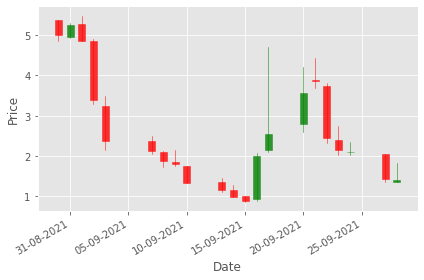

In [148]:
plotStock(recent_df)